In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch

from qgsw import fft, plots
from qgsw.fields.variables.tuples import PSIQT
from qgsw.models.qg.stretching_matrix import compute_A, compute_layers_to_mode_decomposition
from qgsw.output import RunOutput
from qgsw.solver.boundary_conditions.base import Boundaries
from qgsw.solver.boundary_conditions.interpolation import BilinearExtendedBoundary, TimeLinearInterpolation
from qgsw.solver.finite_diff import laplacian
from qgsw.solver.helmholtz import compute_laplace_dstI
from qgsw.solver.pv_inversion import InhomogeneousPVInversion
from qgsw.spatial.core.discretization import SpaceDiscretization3D
from qgsw.spatial.core.grid_conversion import points_to_surfaces
from qgsw.specs import defaults
from qgsw.utils.sorting import sort_files
import torch.nn.functional as F
from qgsw import specs

In [71]:
run = RunOutput("../output/g5k/sw_double_gyre_long_hr")

H = run.summary.configuration.model.h
g_prime = run.summary.configuration.model.g_prime
f0 = run.summary.configuration.physics.f0
A = compute_A(
    H = H,
    g_prime = g_prime
)
space=SpaceDiscretization3D.from_config(
    run.summary.configuration.space,
    run.summary.configuration.model
)
dx = space.dx
dy = space.dy
y = torch.linspace(
    0.5 * space.dy,
    space.ly - 0.5 * space.dy,
    space.ny,
    **defaults.get()
).unsqueeze(0)
y0 = 0.5 * space.ly
beta_effect = run.summary.configuration.physics.beta_plane.beta * (y - y0)


In [72]:
imin, imax = 16,48
jmin,jmax = 250, 314
ref_folder = Path("../output/local/qgpsiq_1L_small")
ts, fs = sort_files(files=ref_folder.glob("results_step_*.pt"),prefix="results_step_",suffix=".pt")

# Using Solver

## Without Boundary

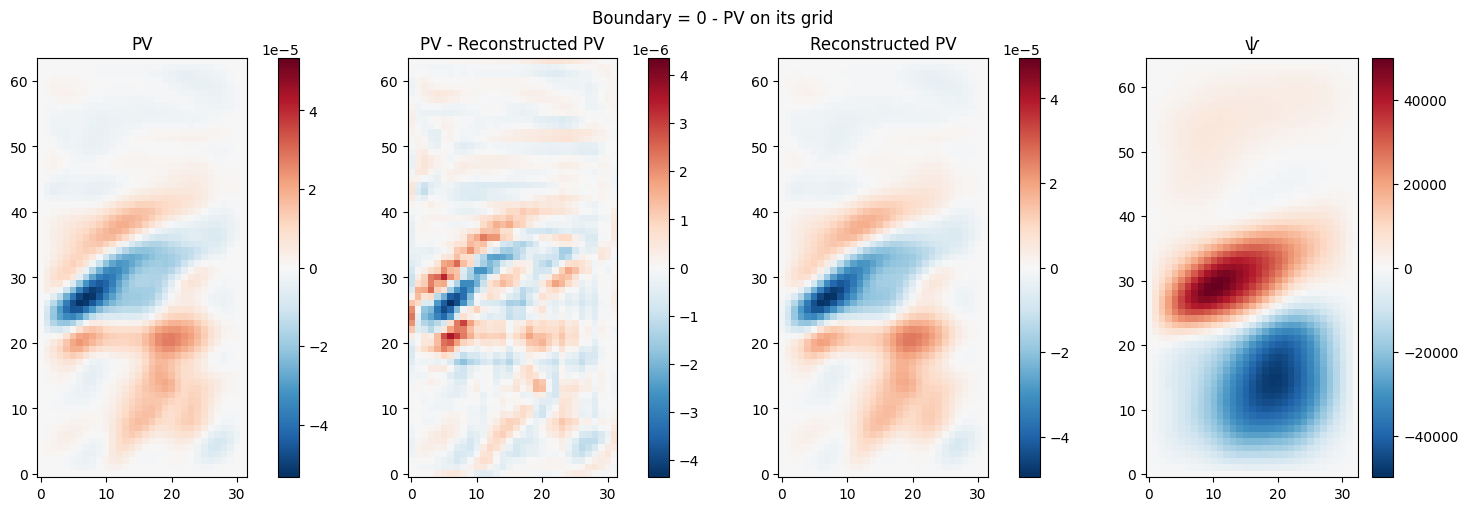

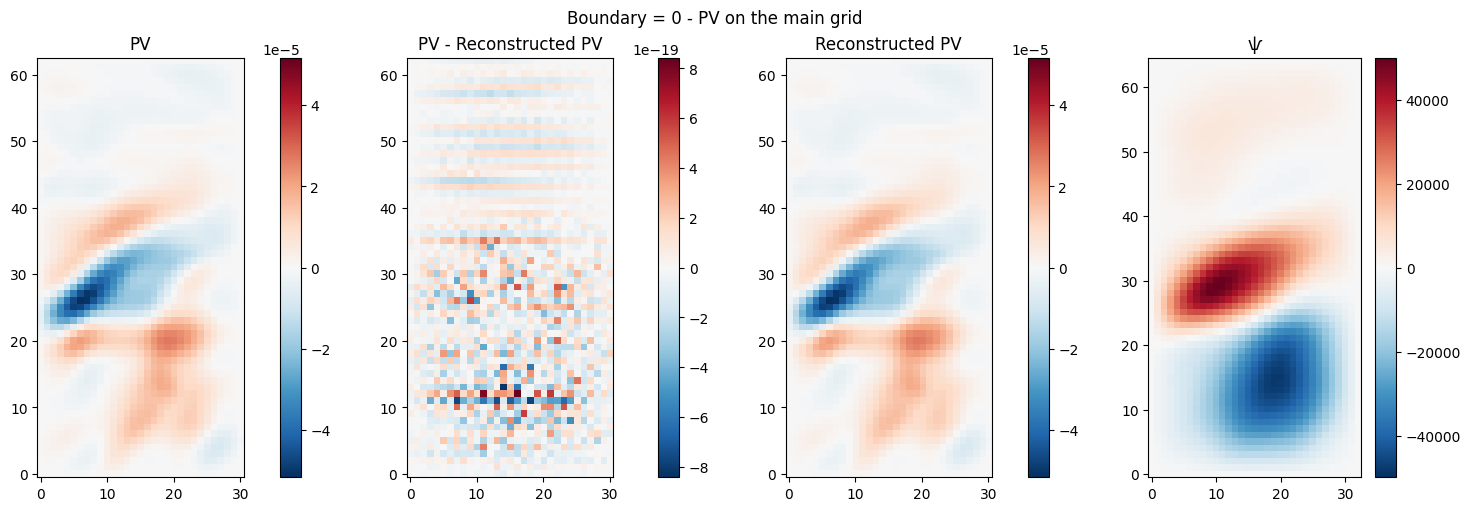

In [73]:
## Load data
_,q, _ = PSIQT.from_file(fs[0])
q = (q[...,:1,:,:]-beta_effect)[...,imin:imax,jmin:jmax]
nx,ny = q.shape[-2:]
tsepcs = specs.from_tensor(q)
boundary = Boundaries(top=q[:,:,:,-1],bottom=q[:,:,:,0],left=q[:,:,0,:],right=q[:,:,-1,:])
boundary_field = BilinearExtendedBoundary(boundary).compute()
q_h = q - boundary_field

# Solve equation
solver = InhomogeneousPVInversion(A,f0,dx,dy)
solver.set_boundaries(
    Boundaries(top=torch.zeros((1,1,nx+1),**tsepcs), bottom=torch.zeros((1,1,nx+1),**tsepcs),left=torch.zeros((1,1,ny+1),**tsepcs),right=torch.zeros((1,1,ny+1),**tsepcs))
)
sf_i,sf_h,sf_b = solver.compute_stream_function_components(q_h)
sf = sf_i + sf_h + sf_b

## Compute q using sf
q_h_reconstruction = points_to_surfaces(F.pad(laplacian(sf,dx,dy),(1,1,1,1)) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf))

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary = 0 - PV on its grid")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()


q_h_reconstruction = laplacian(sf,dx,dy) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf)[...,1:-1,1:-1]
q_h = points_to_surfaces(q_h)

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary = 0 - PV on the main grid")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()

## With Boundary

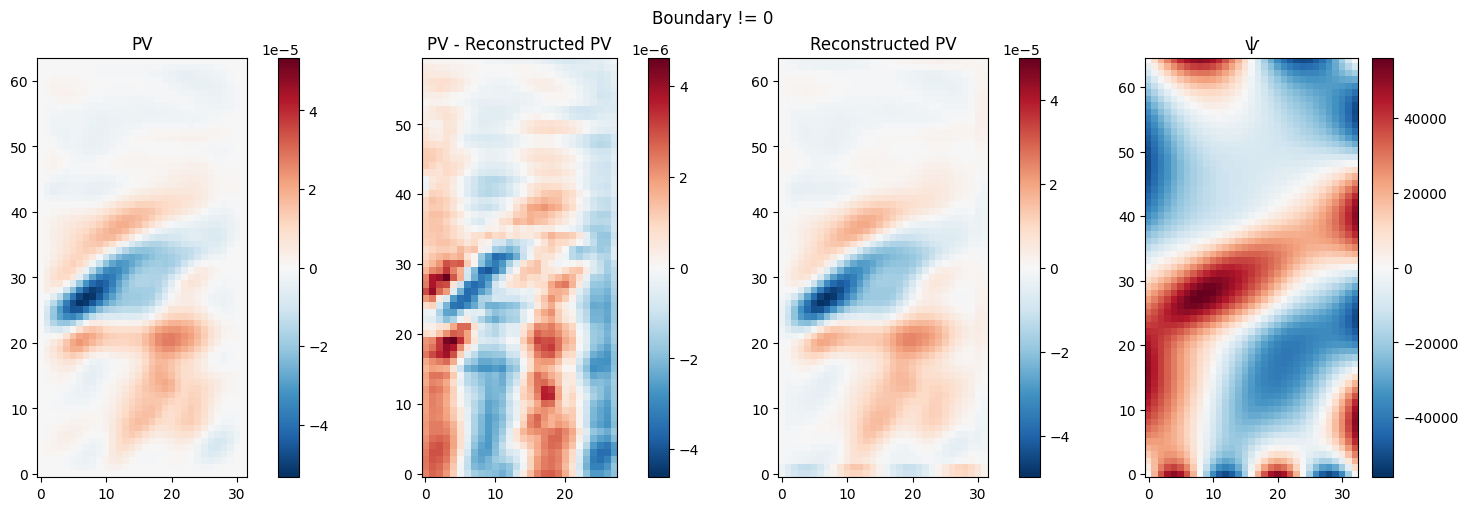

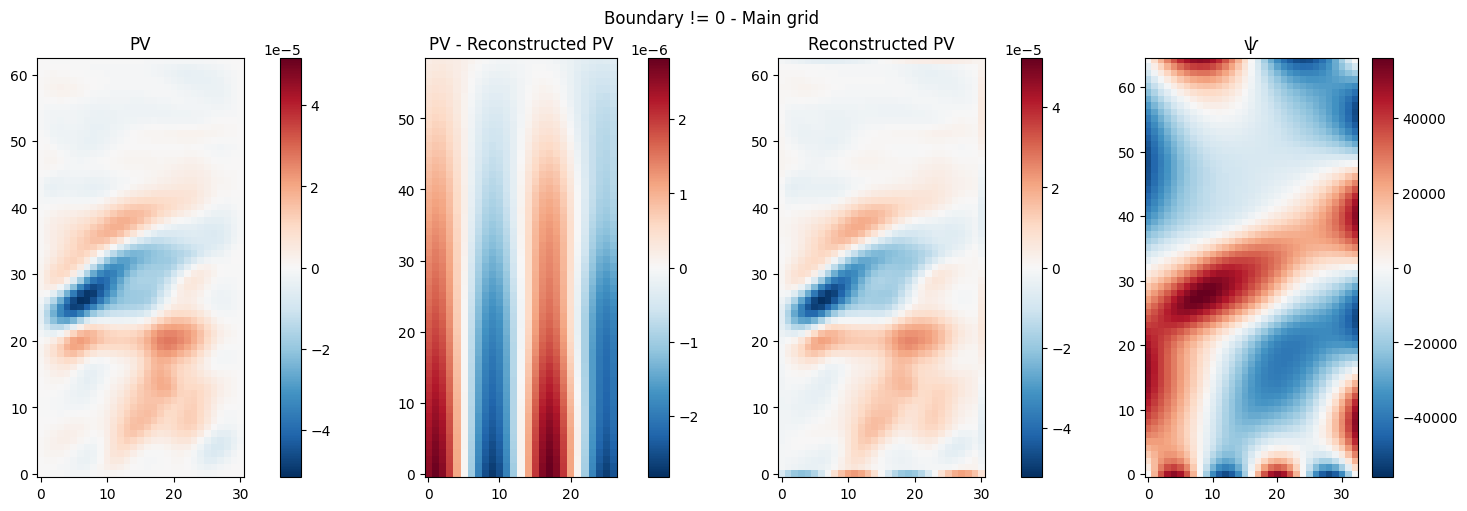

In [74]:

_,q, _ = PSIQT.from_file(fs[0])
q = (q[...,:1,:,:]-beta_effect)[...,imin:imax,jmin:jmax]
nx,ny = q.shape[-2:]
tsepcs = specs. from_tensor(q)
boundary = Boundaries(top=q[:,:,:,-1],bottom=q[:,:,:,0],left=q[:,:,0,:],right=q[:,:,-1,:])
boundary_field = BilinearExtendedBoundary(boundary).compute()
q_h = q - boundary_field
solver = InhomogeneousPVInversion(A,f0,dx,dy)
solver.set_boundaries(
    Boundaries(
        top=sf.abs().max()*torch.sin(torch.arange(nx+1,**tsepcs)/(nx)*2*torch.pi)[None,None,:],
        bottom=sf.abs().max()*torch.sin(2*torch.arange(nx+1,**tsepcs)/(nx)*2*torch.pi)[None,None,:],
        left=sf.abs().max()*torch.sin(torch.arange(ny+1,**tsepcs)/(ny)*2*torch.pi)[None,None,:],
        right=sf.abs().max()*torch.sin(2*torch.arange(ny+1,**tsepcs)/(ny)*2*torch.pi)[None,None,:],)
)
sf_i,sf_h,sf_b = solver.compute_stream_function_components(q_h)
sf = sf_i + sf_h + sf_b

q_h_reconstruction = points_to_surfaces(F.pad(laplacian(sf,dx,dy),(1,1,1,1)) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf))

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary != 0")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0,2:-2,2:-2],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()

q_h_reconstruction = laplacian(sf,dx,dy) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf)[...,1:-1,1:-1]
q_h = points_to_surfaces(q_h)

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary != 0 - Main grid")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0,2:-2,2:-2],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()

# Without solver

## Without Boundary

/home/grigaut/Desktop/code/qgsw/src/qgsw/utils/tensorio.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors: dict[str, torch.Tensor] = torch.load(f)


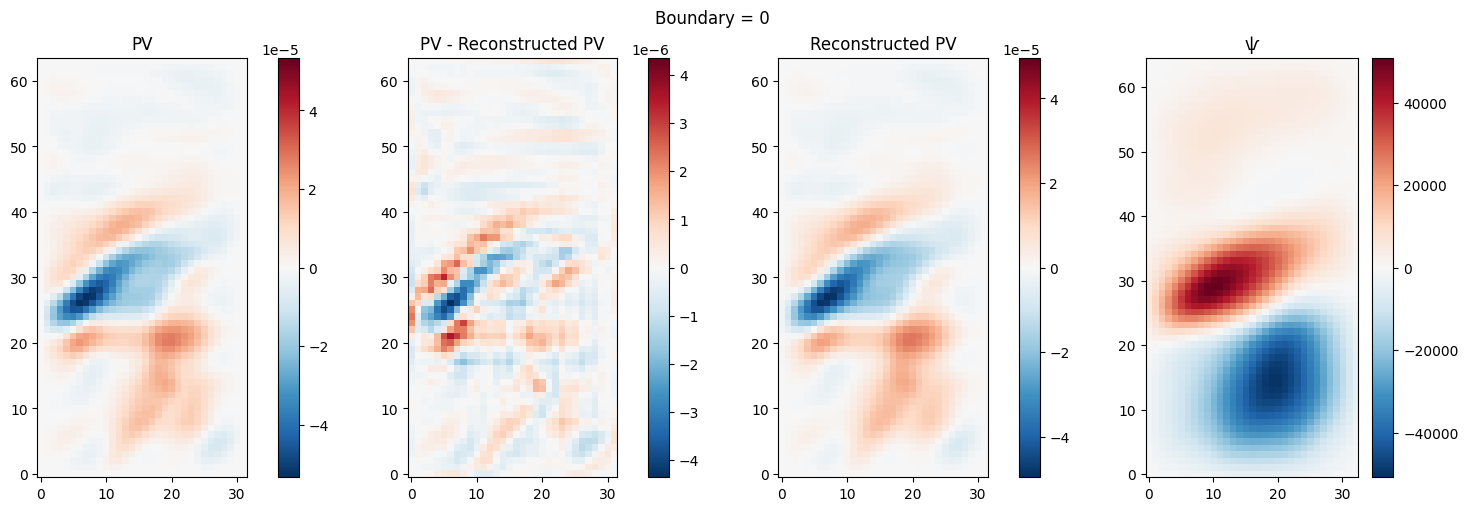

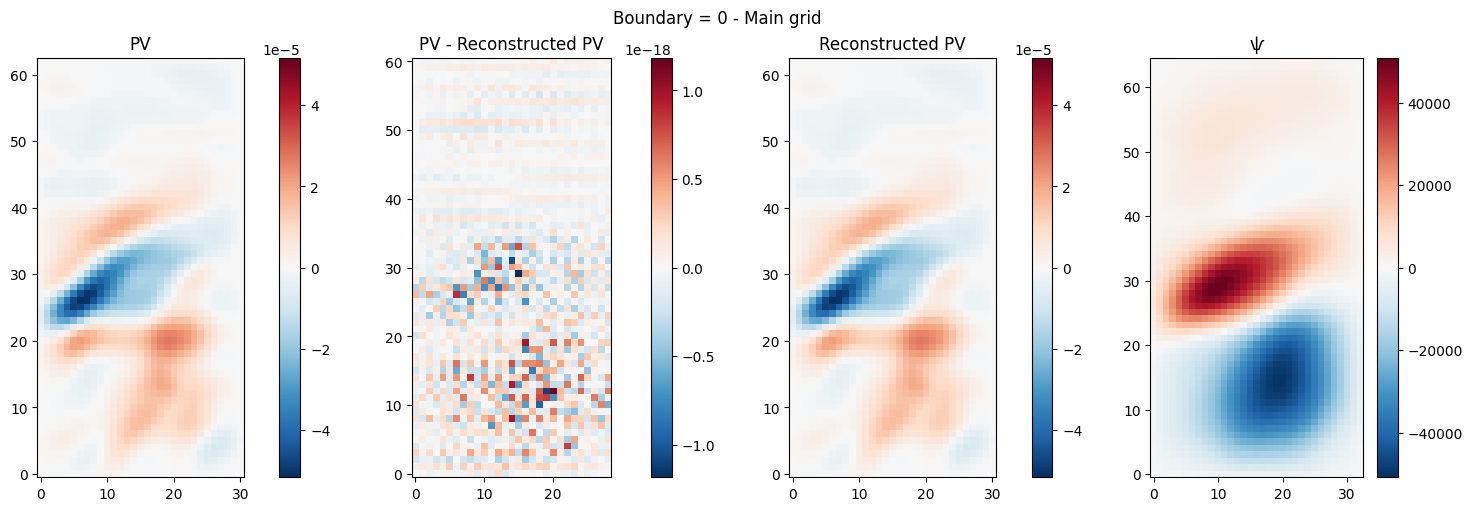

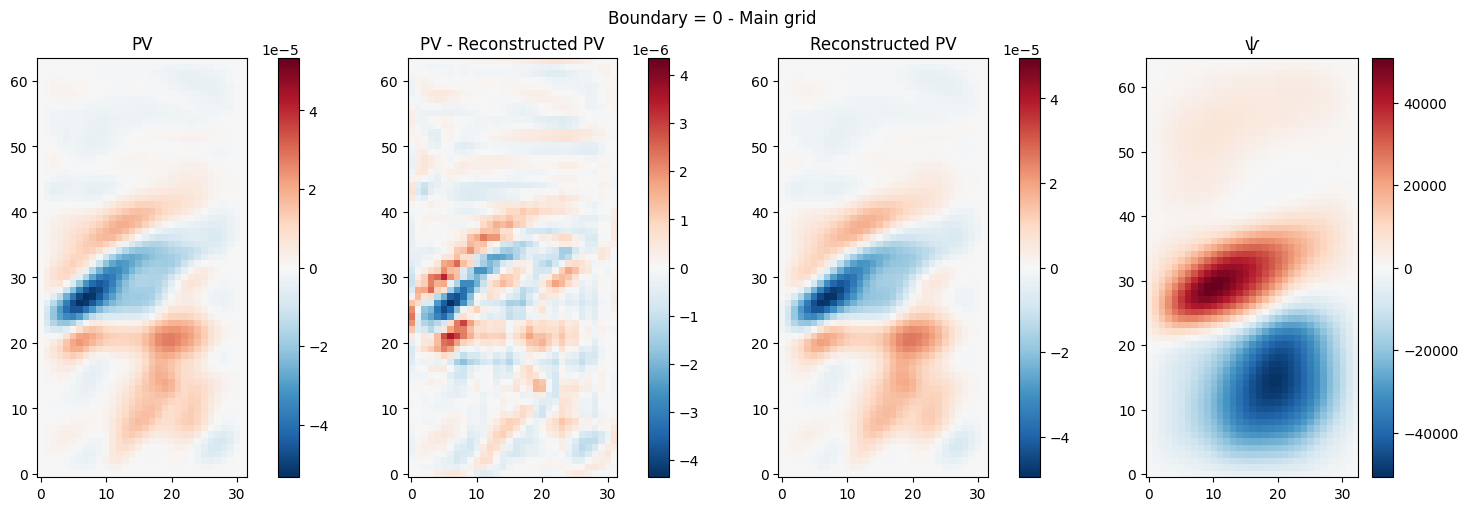

In [82]:
Cm2l, Lambda, Cl2m = compute_layers_to_mode_decomposition(A)
Lambda = Lambda[None,:, None,None]

_,q, _ = PSIQT.from_file(fs[0])
q = (q[...,:1,:,:]-beta_effect)[...,imin:imax,jmin:jmax]
tspecs = specs. from_tensor(q)
nx,ny = q.shape[-2:]

helmholtz_dst = compute_laplace_dstI(nx+2,ny+2,dx,dy,**tspecs).unsqueeze(0).unsqueeze(0)-f0**2 *Lambda

boundary = Boundaries(top=q[:,:,:,-1],bottom=q[:,:,:,0],left=q[:,:,0,:],right=q[:,:,-1,:])
boundary_field = BilinearExtendedBoundary(boundary).compute()
q_h = q - boundary_field

solver = InhomogeneousPVInversion(A,f0,dx,dy)
solver.set_boundaries(
    Boundaries(top=torch.zeros((1,1,nx+1),**tspecs), bottom=torch.zeros((1,1,nx+1),**tspecs),left=torch.zeros((1,1,ny+1),**tspecs),right=torch.zeros((1,1,ny+1),**tspecs))
)
sf_h = solver.psiq_h.psi
sf_b = solver.psiq_b.psi

q_h_= points_to_surfaces(F.pad(q_h,(1,1,1,1)))

rhs = torch.einsum("lm,...mxy->...lxy", Cl2m, q_h_)
sf_i = fft.dstI2D(fft.dstI2D(rhs) / helmholtz_dst)
sf_i = torch.einsum("lm,...mxy->...lxy", Cm2l,sf_i)

sf = sf_i + sf_h + sf_b
q_h_reconstruction = points_to_surfaces(F.pad(laplacian(sf,dx,dy),(1,1,1,1)) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf))

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary = 0")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()

q_h_reconstruction = laplacian(sf,dx,dy) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf)[...,1:-1,1:-1]
q_h = q - boundary_field
q_h = points_to_surfaces(q_h)

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary = 0 - Main grid")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0,1:-1,1:-1],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()

q_h_reconstruction = points_to_surfaces(laplacian(F.pad(sf,(1,1,1,1)),dx,dy) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf))
q_h = q - boundary_field
q_h = q_h

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary = 0 - Main grid")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()

## With boundary

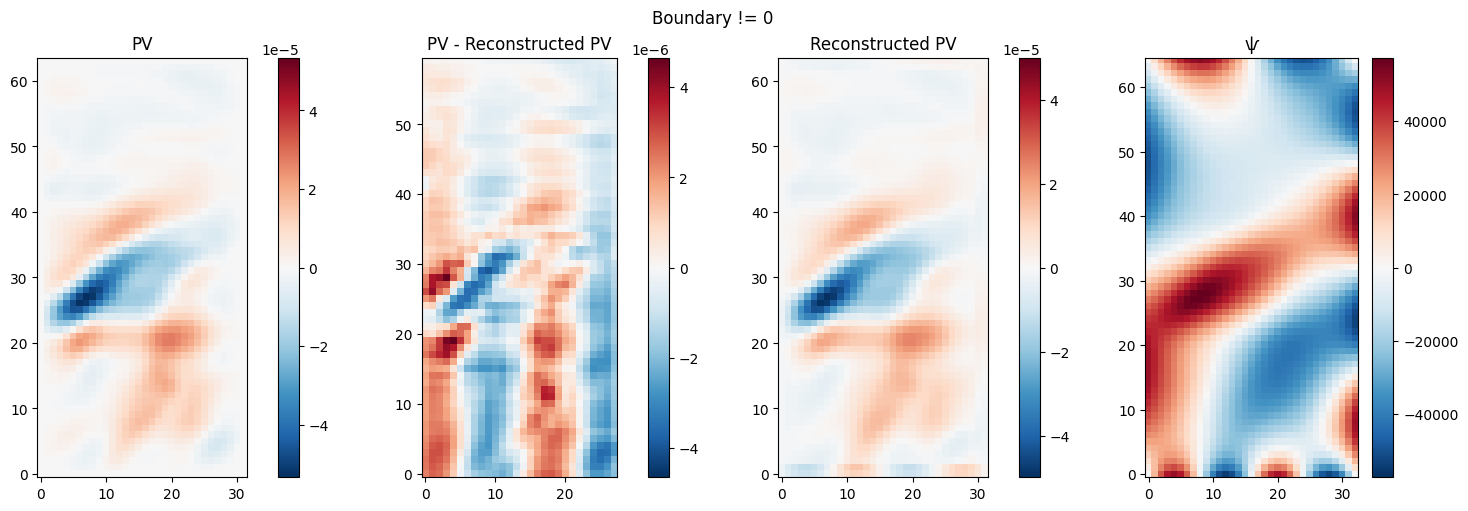

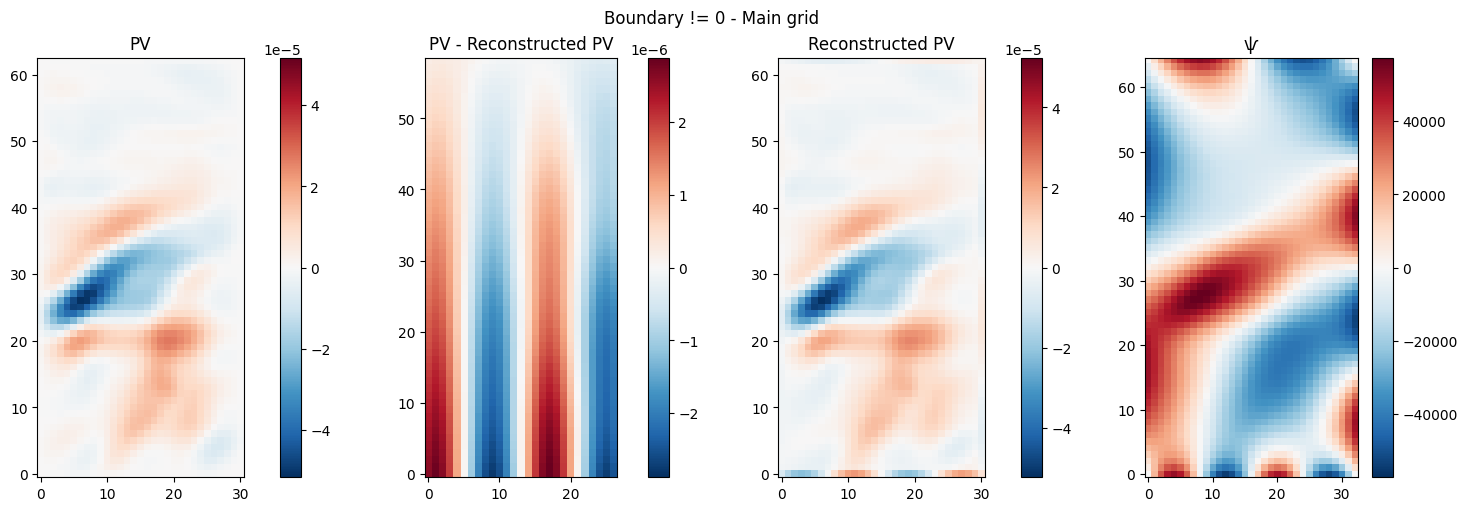

In [76]:
_,q, _ = PSIQT.from_file(fs[0])
q = (q[...,:1,:,:]-beta_effect)[...,imin:imax,jmin:jmax]
nx,ny = q.shape[-2:]
tsepcs = specs. from_tensor(q)
boundary = Boundaries(top=q[:,:,:,-1],bottom=q[:,:,:,0],left=q[:,:,0,:],right=q[:,:,-1,:])
boundary_field = BilinearExtendedBoundary(boundary).compute()
q_h = q - boundary_field
solver = InhomogeneousPVInversion(A,f0,dx,dy)
solver.set_boundaries(
    Boundaries(
        top=sf.abs().max()*torch.sin(torch.arange(nx+1,**tsepcs)/(nx)*2*torch.pi)[None,None,:],
        bottom=sf.abs().max()*torch.sin(2*torch.arange(nx+1,**tsepcs)/(nx)*2*torch.pi)[None,None,:],
        left=sf.abs().max()*torch.sin(torch.arange(ny+1,**tsepcs)/(ny)*2*torch.pi)[None,None,:],
        right=sf.abs().max()*torch.sin(2*torch.arange(ny+1,**tsepcs)/(ny)*2*torch.pi)[None,None,:],)
)


q_h_= points_to_surfaces(F.pad(q_h,(1,1,1,1)))

rhs = torch.einsum("lm,...mxy->...lxy", Cl2m, q_h_)
sf_i = fft.dstI2D(fft.dstI2D(rhs) / helmholtz_dst)
sf_i = torch.einsum("lm,...mxy->...lxy", Cm2l,sf_i)

sf_h = solver.psiq_h.psi
sf_b = solver.psiq_b.psi

sf = sf_i + sf_h + sf_b

q_h_reconstruction = points_to_surfaces(F.pad(laplacian(sf,dx,dy),(1,1,1,1)) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf))

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary != 0")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0,2:-2,2:-2],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()

q_h_reconstruction = laplacian(sf,dx,dy) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf)[...,1:-1,1:-1]
q_h = points_to_surfaces(q_h)

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary != 0 - Main grid")
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])
plots.imshow((q_h - q_h_reconstruction)[0,0,2:-2,2:-2],ax=axs[0,1],title="PV - Reconstructed PV")
plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")
plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")
plt.show()

# Interpolation

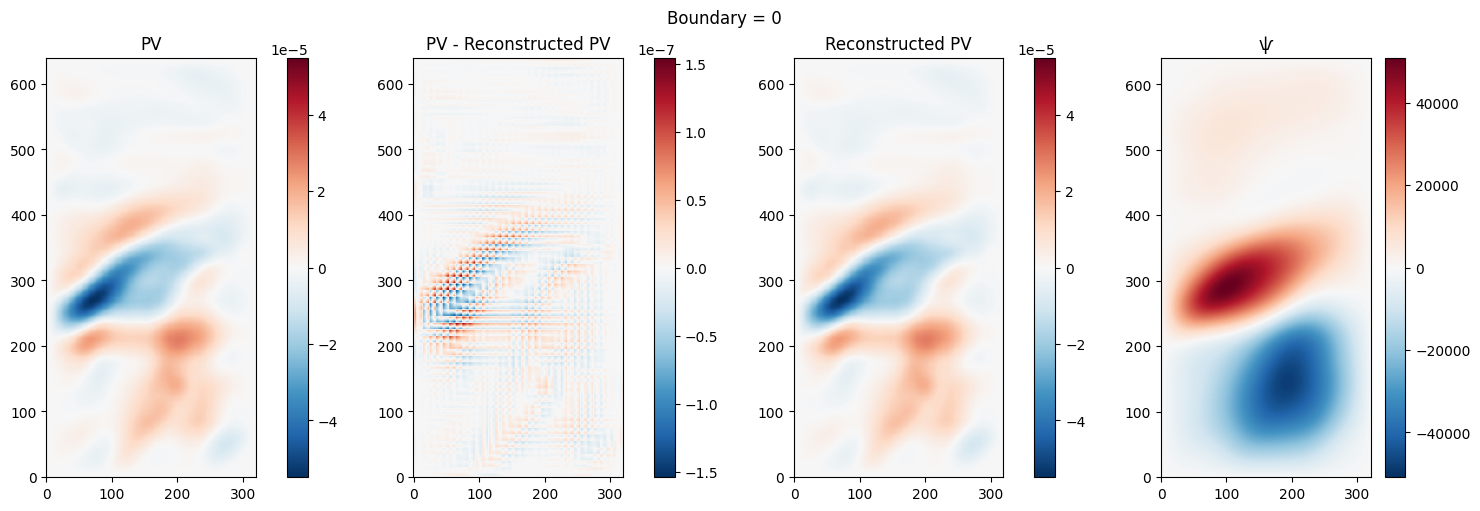

In [88]:
scale = 10

fig,axs = plt.subplots(1,4,squeeze=False,constrained_layout=True,figsize=(15,5))
fig.suptitle("Boundary = 0")
_,q, _ = PSIQT.from_file(fs[0])
q = (q[...,:1,:,:]-beta_effect)[...,imin:imax,jmin:jmax]
tspecs = specs. from_tensor(q)
nx,ny = q.shape[-2:]
q = F.interpolate(q,scale_factor=scale,mode="bicubic")
nx,ny = q.shape[-2:]

helmholtz_dst = compute_laplace_dstI(nx+2,ny+2,dx/scale,dy/scale,**tspecs).unsqueeze(0).unsqueeze(0)-f0**2 *Lambda

tsepcs = specs. from_tensor(q)
boundary = Boundaries(top=q[:,:,:,-1],bottom=q[:,:,:,0],left=q[:,:,0,:],right=q[:,:,-1,:])
boundary_field = BilinearExtendedBoundary(boundary).compute()
q_h = q - boundary_field
plots.imshow(q_h[0,0],title="PV",ax=axs[0,0])

solver = InhomogeneousPVInversion(A,f0,dx/scale,dy/scale)
solver.set_boundaries(
    Boundaries(top=torch.zeros((1,1,nx+1),**tsepcs), bottom=torch.zeros((1,1,nx+1),**tsepcs),left=torch.zeros((1,1,ny+1),**tsepcs),right=torch.zeros((1,1,ny+1),**tsepcs))
)
sf_h = solver.psiq_h.psi
sf_b = solver.psiq_b.psi

rhs = torch.einsum("lm,...mxy->...lxy", Cl2m, points_to_surfaces(F.pad(q_h,(1,1,1,1))))
sf_i = fft.dstI2D(fft.dstI2D(rhs) / helmholtz_dst)
sf_i = torch.einsum("lm,...mxy->...lxy", Cm2l,sf_i)

sf = sf_i + sf_h + sf_b

plots.imshow(sf[0,0],ax=axs[0,3], title="ѱ")

q_h_reconstruction = points_to_surfaces(F.pad(laplacian(sf,dx/scale,dy/scale),(1,1,1,1)) - f0**2 * torch.einsum("lm,...mxy->...lxy",A,sf))

plots.imshow(q_h_reconstruction[0,0],ax=axs[0,2], title="Reconstructed PV")

plots.imshow((q_h - q_h_reconstruction)[0,0],ax=axs[0,1],title="PV - Reconstructed PV")

plt.show()